# Preprocessing the OpenSLR Dataset via spectrogram generation and feature extraction

### 1. Pre-processing the dataset

Because the dataset is loaded into different folders, we can remove the hierarchy while maintaining the text files, as they are based on name. The following bash/Python commands were used for this process (note this requires the following packages to be installed: *ffmpeg*):

```
$ find . -type f -exec mv {} . \;
$ find . -type d -empty -delete
$ cat *.txt >> tmp
$ rm ./*.txt
$ mv tmp transcripts.txt
$ for fl in *.flac; do ffmpeg -i $fl $(basename $fl .flac).wav; done;
```

In [45]:
import csv
import os
import ast
import pydub
import numpy as np
from pydub import AudioSegment
from scipy import signal
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import pandas
from PIL import Image
import itertools
import IPython

In [58]:
# Note the spectrogram generation code is heavily adapted from my 9th grade quest project at https://github.com/bcho04/music-classification.

def generate_spectrogram(fl, verbose=False, standardize=False, normalize=False):
    sound = AudioSegment.from_file(fl)
    
    sound = sound.set_frame_rate(44100) # Set sample rate and make the audio "mono" instead of "stereo"
    sound = sound.set_channels(1) # Mono, not stereo audio.

    samples = np.array(sound.get_array_of_samples())
    samples_float = librosa.util.buf_to_float(samples, n_bytes=2, dtype=np.float32)

    stft = librosa.core.stft(samples_float, n_fft=2048) # Calculate the STFT and convert to dB scale
    stft_db = librosa.amplitude_to_db(abs(stft))

    # Replace any NAN values with 0.
    stft_db[np.isnan(stft_db)] = 0 # Replace all np.nan with 0, to make further computation cleaner.
    
    location_counter = 0
    for clip in stft_db:
        if(standardize == True): # Standardize the spectrogram
            clip = (clip - np.mean(clip)) / np.std(clip)
            stft_db[location_counter] = clip
            location_counter += 1
        if(normalize == True): # Normalize the spectrogram (note this normalizes the standardized version if both standardize and normalize are True)
            sample_min = np.min(clip)
            sample_max = np.max(clip)
            for row in range(clip.shape[0]): # Normalize the input data.
                clip[row] = (clip[row]-sample_min)/(sample_max-sample_min)
            stft_db[location_counter] = clip
            location_counter += 1

    if(verbose):
        # print(track, stft_db.shape) # display the spectrogram's "metadata" in output
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(stft_db, sr=44100, x_axis='time', y_axis='hz')
        plt.colorbar()
        plt.show()
    else:
        return stft_db

In [59]:
IPython.display.Audio("/Users/bracho/Downloads/LibriSpeech/dev-clean/84-121550-0015.wav")

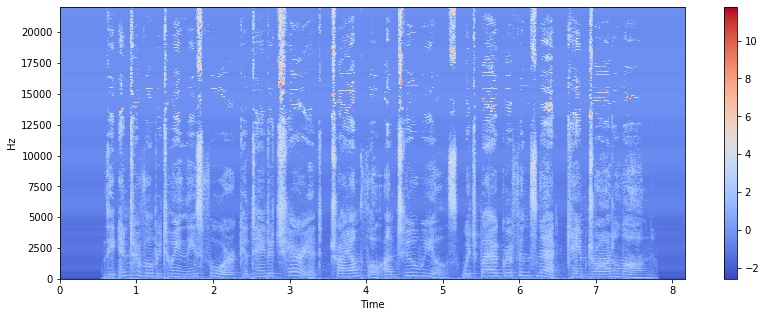

In [60]:
generate_spectrogram("/Users/bracho/Downloads/LibriSpeech/dev-clean/84-121550-0015.wav", verbose=True, standardize=True)

In [61]:
with open("/Users/bracho/Downloads/LibriSpeech/dev-clean/transcripts.txt") as transcripts:
    transcripts_text = transcripts.read().split("\n")
    transcripts_text = [x.split(" ", 1) for x in transcripts_text]

t_df = pandas.DataFrame(transcripts_text)
t_df.columns = ["file", "transcript"]
t_df

,file,transcript
0,1272-128104-0000,MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...
1,1272-128104-0001,NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...
2,1272-128104-0002,HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...
3,1272-128104-0003,HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIG...
4,1272-128104-0004,LINNELL'S PICTURES ARE A SORT OF UP GUARDS AND...
...,...,...
2698,8842-304647-0009,ORGAN OF RUT NOT REASON IS THE LORD WHO FROM T...
2699,8842-304647-0010,WELL TOO IF HE LIKE LOVE WOULD FILCH OUR HOARD...
2700,8842-304647-0011,HEAVEN HELP THAT BODY WHICH A LITTLE MIND HOUS...
2701,8842-304647-0012,DUE TO THEE THEIR PRAISE OF MAIDEN PURE OF TEE...
